# Connect to GDrive and set working directory
## !! Skip if you run in local !!
1. Add a shortcut for working directory('IDPCode') to your drive as depicted below:
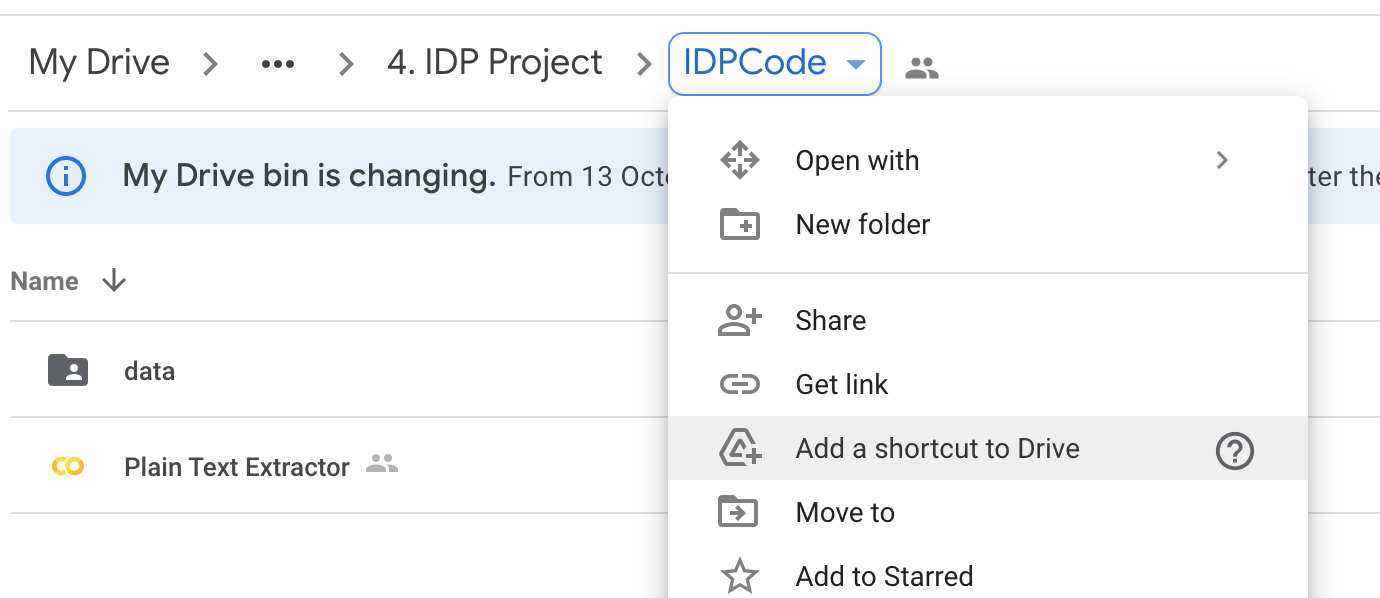
2. Run the command below to connect the GDrive:


In [ ]:
# https://github.com/njanakiev/folderstats
# https://janakiev.com/blog/python-filesystem-analysis/
# https://networkx.org/documentation/stable/
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/IDPCode/

In [ ]:
!pip install xlrd
!pip install spacy
!pip install gensim
!pip install ipython-autotime
!pip install pickle5

# Start from here if you run in local !!

In [11]:
import pandas as pd
import numpy as np
import pickle5 as pickle
import gensim

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# show execution time of cells
%load_ext autotime

# CHANGE PATH FOR THE DATASET FOLDER
DATA_DIRECTORY='/Users/farukcankaya/Google Drive/AllPapers'


The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 867 µs


In [12]:
# Utility functions
def remove_dollar_sign(text):
  '''
  While drawing title count distribution, mathplotlib throws an error.
  Because some titles have dollar sign('$'). This method is used to clear the sign.
  '''
  
  text = str(text).replace('$', '\$')
  return text

import re
import string
def clean_text(text):
  '''
  Eliminates links, non alphanumerics, and punctuation.
  Returns lower case text.
  '''  
  
  # Convert to string
  text = str(text)
  # Remove non-ascii
  text = text.encode('ascii', 'ignore').decode('ascii')
  # Remove links
  text = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+','', text)
  # Remove non-alphanumerics
  text = re.sub('\w*\d\w*', ' ', text)
  # Remove punctuation and lowercase
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text.lower())
  # Remove newline characters
  text = text.replace('\n', ' ')
  # Remove text in square brackets
  text = re.sub(r'\[.*?\]', '', text)
  # Remove words containing numbers
  text = re.sub(r'\w*\d\w*', '', text)
    
  return text

import spacy
nlp = spacy.load('en')
def lemmatizer(text, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):        
  sent = []
  doc = nlp(text)
#  for word in doc:
#    sent.append(word.lemma_)
  sent =  [token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]
    
  return " ".join(sent)

# Lemmatization, remove pronouns.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        texts_out.append(lemmatizer(" ".join(sent), allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']))
    return texts_out

def remove_stopwords(text):
  clean_text = []
  for word in text.split(' '):
    if word not in stop_list and (len(word) > 2):
      clean_text.append(word)
  
  return ' '.join(clean_text)

def display_topics(model, feature_names, no_top_words, no_top_topics, topic_names=None):
  count = 0
  for ix, topic in enumerate(model.components_):
    if count == no_top_topics:
      break
    if not topic_names or not topic_names[ix]:
      print("\nTopic ", (ix + 1))
    else:
      print("\nTopic: '",topic_names[ix],"'")
    print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words-1:-1]]))
    count += 1
    
def word_count(text):
    return sum([i.strip(string.punctuation).isalpha() for i in text.split()])
  
from IPython.core.display import display, HTML
def print_html(data):
  display(HTML('<div style="width: 90%">'+data+'</div>'))
  
  
def print_lemmatized(text, colorized_ignored=False, ignore_type='allowed'):
  allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']
  doc_lemma = nlp(text)
  lemms = []
  poses = []
  #colors = ['#f88f88','#DA553F','#045E5B','#731425','#F61E9E','#f44f44','#ff0','#0ff','#f0f']  
  import random
  r = lambda: random.randint(0,255)
  colors = ['#%02X%02X%02X' % (r(),r(),r()) for i in range(30)]

  for token in doc_lemma:
    if token.pos_ not in poses:
      poses.append(token.pos_)

  print(poses)
  for token in doc_lemma:
    if (ignore_type=='allowed' and token.pos_ not in allowed_postags) or (ignore_type=='stop_word' and token.is_stop):
      ignored_color = '#FF8983' if colorized_ignored else colors[poses.index(token.pos_)]
      
      lemms.append('<span style="color: #fff; padding: 0 10px; background-color: '+ignored_color+'"> '+token.lemma_+' </span>')
    else:
      lemms.append(token.lemma_)
      
  print_html('allowed_postags: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[allowed_postags.index(i)]+'"> '+i+' </span>' for i in allowed_postags]))
  print_html('available: '+' '.join(['<span style="color: #fff; padding: 0 10px; background-color: '+colors[poses.index(i)]+'"> '+i+' </span>' for i in poses]))
  print_html(' '.join(lemms))
  
import os
def get_file_name(file_path):
  f = os.path.basename(file_path)
  return f.replace('.pdf', '')


time: 699 ms


# Initial Info about the dataset
The dataset in 'All_Papers_In_Plain_Text_TIKA.pkl' contains extracted text page by page per document. Each document has one row and has columns as much as they need in the dataset. Any datapreprocessing step is not applied to data in 'All_Papers_In_Plain_Text_TIKA.pkl'. It is not even normalized. It has many documents that have just one page. Our purpose here was to test the accuracy value against different datapreprocessing steps as simple as we can. Afterwards, we will do further tests by normalizing the data. So to summerize:
- We use all 15750 document that we have as it is
- We used Tika to extract the texts from PDF documents
- We didn't exclude any documents based on their relavences
- We didn't normalized the data, it may contain wrong extracted text

## You can skip '1. Data pre-processing' section and use  the pre-processed data by the code below:

In [ ]:
dt = pd.read_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl') # https://drive.google.com/file/d/1UIqL13xHHGDlBomMsfin8g6inhuvOGuc/view?usp=sharing

# 1. Data pre-processing

In [3]:
# dt = Dataset Tika
dt = pd.read_pickle('All_Papers_In_Plain_Text_TIKA.pkl') # https://drive.google.com/file/d/1mF88eFEKtni3Sr8jYo2Yo6-rqIunbMgi/view?usp=sharing

time: 8.55 s


## 1.1. Clean text
- Lowercase
- Remove bracket, punctuation and numbers
- Remove links
- Remove newline characters
- Remove text in square brackets
- Remove words containing numbers ???

In [26]:
col_page = [col for col in dt if col.startswith('page') and not col.endswith('_wc')]
col_page_wc = [col for col in dt if col.startswith('page') and col.endswith('_wc')]

time: 9.25 ms


In [ ]:
for page in col_page:
  text_series = dt[page].apply(clean_text)
  dt['cleaned_' + page] = text_series
  dt['cleaned_' + page + '_wc'] = text_series.apply(word_count)

#dt['clean_content'] = dt['content'].apply(clean_text)

#dt3.head(1)['clean_content']

## 1.2. Stopwords

### Find accounting related stop words

from https://sraf.nd.edu/textual-analysis/resources/

In [13]:
stop_words_data1 = open("data/StopWords/StopWords_Auditor.txt", "r").read().lower().split()
stop_words_data2 = open("data/StopWords/StopWords_Currencies.txt", "r").read().lower().split()
stop_words_data3 = open("data/StopWords/StopWords_DatesandNumbers.txt").read().lower().split()
stop_words_data4 = open("data/StopWords/StopWords_Generic.txt").read().lower().split()
stop_words_data5 = open("data/StopWords/StopWords_GenericLong.txt").read().lower().split()
stop_words_data6 = open("data/StopWords/StopWords_Geographic.txt").read().lower().split()
stop_words_data7 = open("data/StopWords/StopWords_Names.txt").read().lower().split()

time: 8.31 ms


In [14]:
stop_words_data2 = list(filter(lambda a : a != "|", stop_words_data2))
stop_words_data3 = list(filter(lambda a : a != "|", stop_words_data3))
stop_words_data6 = list(filter(lambda a : a != "|", stop_words_data6))
stop_words_data7 = list(filter(lambda a : a != "|", stop_words_data7))

time: 2.31 ms


In [15]:
stop_words_data = stop_words_data1 + stop_words_data2 + stop_words_data3 + stop_words_data4 + stop_words_data5 + stop_words_data6 + stop_words_data7

time: 595 µs


In [16]:
# TODO:!!!!
# Find accounting related stop words
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = ['accounting','firms','research','audit','financial','paper','information','les','des','que','dans','sur','par','qui','est','aux','une']
LIST_OF_ACCOUNTING_RELATED_STOP_WORDS = LIST_OF_ACCOUNTING_RELATED_STOP_WORDS + stop_words_data

time: 882 µs


In [17]:
from gensim.parsing.preprocessing import STOPWORDS

stop_list = STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

time: 2.69 ms


In [18]:
stop_list = STOPWORDS

time: 670 µs


In [21]:
len(stop_list)

337

time: 13.7 ms


In [ ]:
stop_list

In [23]:
len(STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS)))

12893

time: 6.46 ms


In [ ]:
STOPWORDS.union(set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS))

In [76]:
ss1 = pd.DataFrame(data=stop_list, columns=['Stop Word'])
ss1.to_excel('english_stopwords.xlsx', engine='xlsxwriter')

time: 111 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [77]:
ss2 = pd.DataFrame(data=set(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), columns=['Stop Word'])
ss2.to_excel('accounting_stopwords.xlsx', engine='xlsxwriter')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 910 ms


## 1.3. Remove stop words

In [27]:
# Remove stopwords
for page in col_page:
  dt['cleaned_stop_words_' + page] = dt['cleaned_' + page].apply(remove_stopwords) # uses 'stop_list' variable

time: 55.3 s


In [28]:
dt[['file_path','cleaned_page_1', 'cleaned_stop_words_page_1']].head(1)

file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   cleaned_page_1  \
0  s t a   j   t f   v   accounting horizons american accounting association vol     no    doi     pp     the effect of system characteristics  stage of adoption  and experience on institutional   explanations for erp systems choice   joseph c  ugrin   synopsis  existing studies have found a linkage between institutional factors and systems adoption  but the literature has overlooked an important question  when is the decision to implement a system influenced by institutional factors  in this paper  the author argues that decisions to adopt systems are not influenced equally by institutional factors  and examines how system characteristics moderate the effects of institutional factors on adoption decisions  specifically decisions to adopt enterprise resource plan  ning hereafter  erp systems  the results of the study reveal that institutional factors  such as mimicry of peers  compliance with industry norms  and coercion from powerful entities influence erp adoption decisions  the results also show that the effects of in

time: 37 ms


## 1.4. Lemmatization

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_' + page] = dt['cleaned_stop_words_' + page].apply(lemmatizer)

In [63]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0]

time: 7.06 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [64]:
print(text)
print("----------------------------")
print(lemmatized_text)

accounting horizons american accounting association vol doi effect characteristics stage adoption experience institutional explanations erp systems choice joseph ugrin synopsis existing studies linkage institutional factors systems adoption literature overlooked important question decision implement influenced institutional factors paper author argues decisions adopt systems influenced equally institutional factors examines characteristics moderate effects institutional factors adoption decisions specifically decisions adopt enterprise resource plan ning erp systems results study reveal institutional factors mimicry peers compliance industry norms coercion powerful entities influence erp adoption decisions results effects institutional factors adoption decisions amplified participants adopted erp benefits difficult quantify enhances organizational interaction supply chain paper author contributes institutional theory literature exploring ditions enhance salience institutional factors c

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [65]:
print_lemmatized(text)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['PROPN', 'VERB', 'NOUN', 'ADJ', 'ADV', 'ADP']


time: 302 ms


In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_all_pages_separetely.pkl')

## 1.5. Stemming
May lead to confusion, think about that again!!!

In [ ]:
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()

def stem_text(text):
    word_list = []
    for word in text.split(' '):
        word_list.append(stemmer.stem(word))
    return ' '.join(word_list)

In [ ]:
for page in col_page:
  dt['cleaned_stop_words_lemmatized_stemmed_' + page] = dt['cleaned_stop_words_lemmatized_' + page].apply(stem_text)

In [ ]:
dt.to_pickle('cleaned_stop_words_lemmatized_stemmed_all_pages_separetely.pkl')

In [66]:
text = dt['cleaned_stop_words_page_1'].head(1)[0]
lemmatized_text = dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0].split()
stemmed_text = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0].split()

stemm_words = []
for i in range(len(stemmed_text)):
  if stemmed_text[i] == lemmatized_text[i]:
    stemm_words.append(stemmed_text[i])
  else:
    stemm_words.append(stemmed_text[i]+'<span style="background-color: #FF8983">'+(lemmatized_text[i])[len(stemmed_text[i]):]+'</span>')

print_html(' '.join(stemm_words))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



time: 5.58 ms


# 2. Prepare Test Content 

In [67]:
print_lemmatized(' '.join(LIST_OF_ACCOUNTING_RELATED_STOP_WORDS), colorized_ignored=False, ignore_type='stop_word')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['NOUN', 'VERB', 'PROPN', 'PUNCT', 'ADJ', 'CCONJ', 'X', 'NUM', 'ADV', 'PRON', 'ADP', 'DET', 'AUX', 'SCONJ', 'INTJ', 'PART']


time: 2.82 s


In [ ]:
dt['content_3'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str)

In [ ]:
dt['content_5'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str)

In [ ]:
dt['content_7'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_7'].apply(str)

In [ ]:
dt['content_10'] = dt['cleaned_stop_words_lemmatized_stemmed_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_7'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_8'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_9'].apply(str) + ' ' \
                + dt['cleaned_stop_words_lemmatized_stemmed_page_10'].apply(str)

In [68]:
print_lemmatized(dt['cleaned_stop_words_page_1'].head(1)[0])
print_lemmatized(dt['cleaned_stop_words_lemmatized_page_1'].head(1)[0])
print_lemmatized(dt['cleaned_stop_words_lemmatized_stemmed_page_1'].head(1)[0])

['PROPN', 'VERB', 'NOUN', 'ADJ', 'ADV', 'ADP']


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV']


['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADP', 'X']


time: 145 ms


In [29]:
dt['content_3'] = dt['cleaned_stop_words_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_3'].apply(str)
dt['content_5'] = dt['cleaned_stop_words_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_5'].apply(str)
dt['content_10'] = dt['cleaned_stop_words_page_1'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_2'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_3'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_4'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_5'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_6'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_7'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_8'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_9'].apply(str) + ' ' \
                + dt['cleaned_stop_words_page_10'].apply(str)

time: 1.86 s


In [30]:
dt3c = pd.DataFrame(dt, columns=['file_path', 'content_3', 'content_5', 'content_10'])

time: 820 ms


In [31]:
dt3c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_path   15751 non-null  object
 1   content_3   15751 non-null  object
 2   content_5   15751 non-null  object
 3   content_10  15751 non-null  object
dtypes: object(4)
memory usage: 492.3+ KB
time: 21.7 ms


In [ ]:
# dt3c.to_pickle('normalized_indexed_lemmatized.pkl')
dt3c.to_pickle('cleaned_content_3_5_10.pkl')

In [ ]:
dt3c.head(1)

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop_list,
                          max_words=500,
                          max_font_size=40, 
                          random_state=42
                         ).generate(str(dt3c['content_10']))

print(wordcloud)

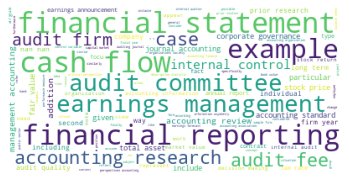

time: 671 ms


In [33]:
import matplotlib.pyplot as plt

fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [34]:
NUM_OF_TOPICS = 30
NUM_OF_WORDS_IN_EACH_TOPIC = 20

time: 413 µs


## Unigrams

In [35]:
from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df2 = pd.DataFrame(common_words, columns = ['unigram' , 'count'])

fig = go.Figure([go.Bar(x=df2['unigram'], y=df2['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} unigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

time: 1min 24s


## Bigrams

In [36]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(dt3c['content_10'], NUM_OF_WORDS_IN_EACH_TOPIC)
df3 = pd.DataFrame(common_words, columns = ['bigram' , 'count'])

fig = go.Figure([go.Bar(x=df3['bigram'], y=df3['count'])])
fig.update_layout(title=go.layout.Title(text="Top {} bigrams in the paper after removing stop words".format(NUM_OF_WORDS_IN_EACH_TOPIC)))
fig.show()

time: 4min 24s


In [37]:
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.sklearn

count_vectorizer = CountVectorizer(analyzer='word',       
                             min_df=3,                       
                             stop_words='english',             
                             lowercase=True,                   
                             token_pattern='[a-zA-Z0-9]{3,}',  
                             max_features=5000,          
                            )

data_vectorized = count_vectorizer.fit_transform(dt3c['content_10'])

lda_model = LatentDirichletAllocation(n_components=NUM_OF_TOPICS, # Number of topics
                                      learning_method='online',
                                      random_state=0,       
                                      n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

time: 4min 59s


## Visualize topics
By default the topics are projected to the 2D plane using PCoA on a distance matrix created using the <a href="https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence">Jensen-Shannon divergence</a> on the topic-term distributions. You can pass in a different multidimensional scaling function via the mds parameter. In addition to <b>pcoa</b>, other provided options are <b>tsne</b> and <b>mmds</b> which operate on the same JS-divergence distance matrix. Both tsne and mmds require that you have sklearn installed. 


Dimension reduction via Jensen-Shannon Divergence &
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html">TSNE - t-distributed Stochastic Neighbor Embedding</a>
- <a href="https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS">MMDS - Metric Multidimensional Scaling</a> <a href="https://scikit-learn.org/stable/auto_examples/manifold/plot_mds.html">Check Example</a>
- <a href="">PCOA - Principal Coordinate Analysis(aka Classical Multidimensional Scaling)</a>

Answer: https://stackoverflow.com/questions/50923430/what-does-the-parameter-mds-mean-in-the-pyldavis-sklearn-prepare-function

We used tsne below. Check for others: https://nbviewer.jupyter.org/github/bmabey/pyLDAvis/blob/master/notebooks/pyLDAvis_overview.ipynb
Also check to learn how LDAVis works: https://cran.r-project.org/web/packages/LDAvis/vignettes/details.pdf
And check the LDAVis from the original paper: https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf
Why LDAVis presentation: https://speakerdeck.com/bmabey/visualizing-topic-models

In [62]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_vectorized, count_vectorizer, mds='tsne')

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
15     119.070190   64.655502       1        1  9.531885
24      54.382130  109.799164       2        1  5.804546
22    -161.423965 -103.744957       3        1  5.361134
23    -135.370758   36.673065       4        1  4.841636
29     177.317215  -66.872452       5        1  4.836575
20     -16.436356  142.453796       6        1  4.615606
14      31.052383  204.777573       7        1  4.588901
12     -25.024384 -186.083466       8        1  4.231862
17     -68.157486   20.934038       9        1  4.083482
0       -3.751695    4.961509      10        1  3.655853
13    -114.470009 -179.605469      11        1  3.621573
25    -110.729126  -40.476776      12        1  3.607980
7       42.552418  -42.789406      13        1  3.380981
9      -10.661536   71.922211      14        1  3.337887
27     112.652969  -16.279951      15        1  3.323534
3     -195.499146  -25.853945      16        1  3.316541
4     -207.165924   66.070419      17        1  2.922849
26      10.217649 -110.752060      18        1  2.734098
16     -81.255081   96.477776      19        1  2.554648
21     -77.253441  192.755219      20        1  2.382061
11     182.353027  110.412880      21        1  2.358350
8       89.766510  -93.997673      22        1  2.345184
19     -36.483528  -52.542774      23        1  2.298984
28     -72.052170 -112.144821      24        1  2.064012
6      144.822769 -150.811508      25        1  1.858343
2     -148.475357  135.678162      26        1  1.753668
5      189.811615   17.382956      27        1  1.350109
1       56.555355   33.755768      28        1  1.279936
18      58.988537 -178.376541      29        1  1.079459
10     110.556717  164.236694      30        1  0.878321, topic_info=                   Term           Freq          Total Category  logprob  \
366               audit  215471.000000  215471.000000  Default  30.0000   
1482           earnings  186513.000000  186513.000000  Default  29.0000   
4570                tax  111605.000000  111605.000000  Default  28.0000   
1901              firms  299909.000000  299909.000000  Default  27.0000   
40           accounting  378330.000000  378330.000000  Default  26.0000   
3995               risk  108589.000000  108589.000000  Default  25.0000   
2371        information  206661.000000  206661.000000  Default  24.0000   
1363         disclosure   75551.000000   75551.000000  Default  23.0000   
372            auditors   98105.000000   98105.000000  Default  22.0000   
4821              value  136032.000000  136032.000000  Default  21.0000   
371             auditor   71827.000000   71827.000000  Default  20.0000   
1891          financial  196356.000000  196356.000000  Default  19.0000   
3329        performance  109345.000000  109345.000000  Default  18.0000   
2819             market  130602.000000  130602.000000  Default  17.0000   
206            analysts   48172.000000   48172.000000  Default  16.0000   
1900               firm  170704.000000  170704.000000  Default  15.0000   
2305             income   62256.000000   62256.000000  Default  14.0000   
627                cash   56630.000000   56630.000000  Default  13.0000   
4396              stock   74550.000000   74550.000000  Default  12.0000   
4786         university   74754.000000   74754.000000  Default  11.0000   
1931           forecast   35972.000000   35972.000000  Default  10.0000   
2352           industry   59456.000000   59456.000000  Default   9.0000   
2061         governance   41859.000000   41859.000000  Default   8.0000   
1934          forecasts   34448.000000   34448.000000  Default   7.0000   
1165               debt   37539.000000   37539.000000  Default   6.0000   
1037          corporate   69064.000000   69064.000000  Default   5.0000   
842        compensation   31382.000000   31382.000000  Default   4.0000   
2788         management  149969.0

time: 29.1 s


In [39]:
print(count_vectorizer)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=5000, min_df=3,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='[a-zA-Z0-9]{3,}',
                tokenizer=None, vocabulary=None)
time: 6.08 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [40]:
print(data_vectorized.toarray())

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[[ 1  0  0 ...  0  0  0]
 [ 2  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  5  0 ...  0  0  0]
 [ 0 11  0 ...  0  0  0]
 [ 0  5  0 ...  0  0  0]]
time: 433 ms


In [41]:
topic_names = []
for i in range(NUM_OF_TOPICS):
  topic_names.append("Topic {}".format(i+1))

time: 484 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [42]:
def show_topics(vectorizer, lda_model, n_words):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=count_vectorizer, lda_model=lda_model, n_words=NUM_OF_WORDS_IN_EACH_TOPIC)

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords['topic_theme'] = topic_names
df_topic_keywords.set_index('topic_theme', inplace=True)
df_topic_keywords.T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic_theme         Topic 1        Topic 2       Topic 3      Topic 4  \
Word 0               public           fund          debt  information   
Word 1           government          funds  conservatism   disclosure   
Word 2               sector         health          loan  disclosures   
Word 3                state        revenue   information    investors   
Word 4            political          costs    accounting        firms   
Word 5                local           care         firms      reports   
Word 6             economic           cost       private    voluntary   
Word 7              private            maj     financing    reporting   
Word 8                  new         public     covenants       report   
Word 9           accounting       services     financial    financial   
Word 10            national       hospital     contracts       annual   
Word 11                 les      hospitals       lenders    companies   
Word 12              policy          total         costs      quality   
Word 13           financial       spending   contracting         firm   
Word 14             reforms         sector         loans     disclose   
Word 15      accountability  organizations  conservative      capital   
Word 16         governments       revenues     borrowers     managers   
Word 17            services         budget        credit     research   
Word 18              reform        service        agency      content   
Word 19          corruption     government          firm    disclosed   

topic_theme      Topic 5       Topic 6    Topic 7         Topic 8     Topic 9  \
Word 0          earnings  compensation        tax   environmental        risk   
Word 1          analysts           pay     income          social       banks   
Word 2          forecast       pension      taxes       reporting        bank   
Word 3         forecasts     employees       rate       corporate     capital   
Word 4           analyst    incentives  avoidance  accountability      credit   
Word 5       information       workers      rates       companies   financial   
Word 6        management     incentive   taxation  sustainability      market   
Word 7           quarter         labor  corporate             csr      afaanz   
Word 8              firm      employee    capital   organisations     finance   
Word 9             firms         bonus   transfer    stakeholders      rating   
Word 10             news         plans    taxable      management        bond   
Word 11            prior      benefits    foreign         reports      assets   
Word 12         research      contract     effect  organisational     ratings   
Word 13         accuracy     contracts   marginal    organisation      crisis   
Word 14         managers          plan    effects     stakeholder     banking   
Word 15         guidance          wage  taxpayers      legitimacy       risks   
Word 16             year       benefit    revenue        research  investment   
Word 17        investors      increase   planning           study       asset   
Word 18           sample    employment  effective          report      equity   
Word 19            stock        salary   increase     performance        rate   

topic_theme     Topic 10     Topic 11    Topic 12        Topic 13  \
Word 0        accounting     earnings       value     performance   
Word 1         financial         gaap      equity        managers   
Word 2              fair        items       stock        measures   
Word 3         reporting          non       price         control   
Word 4             value       income    dividend      management   
Word 5        statements          pro      market            cost   
Word 6         standards     managers      option             use   
Word 7         statement  adjustments     options          budget   
Word 8          standard      special   valuation           based   
Word 9       information        forma     capital        research   
Word 

time: 79.9 ms


# 2. Topic Modeling

In [43]:
# Create Document - Topic Matrix
lda_output2 = lda_model.transform(data_vectorized)

# column names
topicnames = df_topic_keywords.T.columns

# index names
docnames = ["Doc" + str(i) for i in range(len(dt3c))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output2, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

df_document_topic.reset_index(inplace=True)
df_sent_topic= pd.merge(dt3c, df_document_topic, left_index=True, right_index=True)
df_sent_topic.drop('index', axis=1, inplace=True)

df_topic_theme = df_sent_topic[['file_path', 'dominant_topic']]

def label_theme(row):
    return "Topic " + str(row)
        
df_topic_theme['dominant_topic_theme'] = df_topic_theme['dominant_topic'].apply(label_theme)
df_topic_theme.head(15)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

<ipython-input-43-9689e41583c7>:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



file_path  \
0   /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
1   /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf   
2   /Users/farukcankaya/Google Drive/AllPapers/8_AH/611_AH.pdf   
3    /Users/farukcankaya/Google Drive/AllPapers/8_AH/62_AH.pdf   
4   /Users/farukcankaya/Google Drive/AllPapers/8_AH/294_AH.pdf   
5   /Users/farukcankaya/Google Drive/AllPapers/8_AH/123_AH.pdf   
6   /Users/farukcankaya/Google Drive/AllPapers/8_AH/672_AH.pdf   
7   /Users/farukcankaya/Google Drive/AllPapers/8_AH/394_AH.pdf   
8   /Users/farukcankaya/Google Drive/AllPapers/8_AH/398_AH.pdf   
9   /Users/farukcankaya/Google Drive/AllPapers/8_AH/298_AH.pdf   
10  /Users/farukcankaya/Google Drive/AllPapers/8_AH/603_AH.pdf   
11  /Users/farukcankaya/Google Drive/AllPapers/8_AH/152_AH.pdf   
12  /Users/farukcankaya/Google Drive/AllPapers/8_AH/703_AH.pdf   
13   /Users/farukcankaya/Google Drive/AllPapers/8_AH/13_AH.pdf   
14  /Users/farukcankaya/Google Drive/AllPapers/8_AH/386_AH.pdf   

    dominant_topic dominant_topic_theme  
0               22             Topic 22  
1               19             Topic 19  
2               14             Topic 14  
3                0              Topic 0  
4                9              Topic 9  
5               26             Topic 26  
6                4              Topic 4  
7               14             Topic 14  
8               20             Topic 20  
9               22             Topic 22  
10              14             Topic 14  
11               9              Topic 9  
12              22             Topic 22  
13              19             Topic 19  
14              20             Topic 20

time: 24.9 s


## Make Prediction

In [44]:
print(lda_output.shape) # (11682, 8)
topic_sum = pd.DataFrame(np.sum(lda_output, axis = 1))
print(topic_sum.shape) # (11682, 1)

(15751, 30)
(15751, 1)
time: 1.76 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [45]:
column_names = ['file_path', 'content_10'] + topic_names + ['sum']

# Turn our docs_nmf array into a data frame
doc_topic_df = pd.DataFrame(data = lda_output)

# Merge all of our article metadata and name columns
doc_topic_df = pd.concat([dt3c[['file_path', 'content_10']], 
                          doc_topic_df, topic_sum], axis = 1)


time: 7.99 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [46]:
doc_topic_df.columns = column_names

time: 563 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [47]:
doc_topic_df.head(1)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



file_path  \
0  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

time: 35.3 ms


In [48]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15751 non-null  object 
 1   content_10  15751 non-null  object 
 2   Topic 1     15751 non-null  float64
 3   Topic 2     15751 non-null  float64
 4   Topic 3     15751 non-null  float64
 5   Topic 4     15751 non-null  float64
 6   Topic 5     15751 non-null  float64
 7   Topic 6     15751 non-null  float64
 8   Topic 7     15751 non-null  float64
 9   Topic 8     15751 non-null  float64
 10  Topic 9     15751 non-null  float64
 11  Topic 10    15751 non-null  float64
 12  Topic 11    15751 non-null  float64
 13  Topic 12    15751 non-null  float64
 14  Topic 13    15751 non-null  float64
 15  Topic 14    15751 non-null  float64
 16  Topic 15    15751 non-null  float64
 17  Topic 16    15751 non-null  float64
 18  Topic 17    15751 non-null  float64
 19  Topic 18    15751 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [49]:
# Remove articles with topic sum = 0, then drop sum column
doc_topic_df = doc_topic_df[doc_topic_df['sum'] != 0]
doc_topic_df.drop(columns = 'sum', inplace = True)

# Reset index then save
doc_topic_df.reset_index(drop = True, inplace = True)
#doc_topic_df.to_pickle('counter_vectorizer_LDA_8topics_stemmed.pkl')

time: 10.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [50]:
doc_topic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   file_path   15751 non-null  object 
 1   content_10  15751 non-null  object 
 2   Topic 1     15751 non-null  float64
 3   Topic 2     15751 non-null  float64
 4   Topic 3     15751 non-null  float64
 5   Topic 4     15751 non-null  float64
 6   Topic 5     15751 non-null  float64
 7   Topic 6     15751 non-null  float64
 8   Topic 7     15751 non-null  float64
 9   Topic 8     15751 non-null  float64
 10  Topic 9     15751 non-null  float64
 11  Topic 10    15751 non-null  float64
 12  Topic 11    15751 non-null  float64
 13  Topic 12    15751 non-null  float64
 14  Topic 13    15751 non-null  float64
 15  Topic 14    15751 non-null  float64
 16  Topic 15    15751 non-null  float64
 17  Topic 16    15751 non-null  float64
 18  Topic 17    15751 non-null  float64
 19  Topic 18    15751 non-nul

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [51]:
doc_topic_df[['file_path']+topic_names].head(3).T

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



0  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/711_AH.pdf   
Topic 1                                                   1.35833e-05   
Topic 2                                                   1.35833e-05   
Topic 3                                                   1.35833e-05   
Topic 4                                                   1.35833e-05   
Topic 5                                                   1.35833e-05   
Topic 6                                                   1.35833e-05   
Topic 7                                                   1.35833e-05   
Topic 8                                                     0.0211656   
Topic 9                                                   1.35833e-05   
Topic 10                                                  1.35833e-05   
Topic 11                                                  1.35833e-05   
Topic 12                                                  1.35833e-05   
Topic 13                                                     0.111861   
Topic 14                                                  1.35833e-05   
Topic 15                                                  1.35833e-05   
Topic 16                                                     0.159594   
Topic 17                                                     0.145517   
Topic 18                                                  1.35833e-05   
Topic 19                                                  1.35833e-05   
Topic 20                                                  1.35833e-05   
Topic 21                                                    0.0622524   
Topic 22                                                  1.35833e-05   
Topic 23                                                     0.380861   
Topic 24                                                    0.0720716   
Topic 25                                                  1.35833e-05   
Topic 26                                                  1.35833e-05   
Topic 27                                                  1.35833e-05   
Topic 28                                                    0.0463779   
Topic 29                                                  1.35833e-05   
Topic 30                                                  1.35833e-05   

                                                                    1  \
file_path  /Users/farukcankaya/Google Drive/AllPapers/8_AH/140_AH.pdf   
Topic 1                                                      0.130198   
Topic 2                                                     0.0197014   
Topic 3                                                   1.34517e-05   
Topic 4                                                   1.34517e-05   
Topic 5                                                   1.34517e-05   
Topic 6                                                    0.00210826   
Topic 7                                                    0.00657178   
Topic 8                                                   1.34517e-05   
Topic 9                                                    0.00370938   
Topic 10                                                  1.34517e-05   
Topic 11                                                  1.34517e-05   
Topic 12                                                  1.34517e-05   
Topic 13                                                    0.0629563   
Topic 14                                                  1.34517e-05   
Topic 15                                                    0.0142559   
Topic 16                                                     0.129728   
Topic 17                                                  1.34517e-05   
Topic 18                                                    0.0315326   
Topic 19                                                    0.0118022   
Topic 20                                                     0.252983   
Topic 21                                                  1.34517e-05   
Topic 22                                            

time: 14.7 ms


In [52]:
topic_array = np.array(doc_topic_df[topic_names])

print(topic_array.shape)

print(topic_array[0])

(15751, 30)
[1.35832654e-05 1.35832654e-05 1.35832654e-05 1.35832654e-05
 1.35832654e-05 1.35832654e-05 1.35832654e-05 2.11656171e-02
 1.35832654e-05 1.35832654e-05 1.35832654e-05 1.35832654e-05
 1.11861001e-01 1.35832654e-05 1.35832654e-05 1.59594103e-01
 1.45517197e-01 1.35832654e-05 1.35832654e-05 1.35832654e-05
 6.22524365e-02 1.35832654e-05 3.80861322e-01 7.20715799e-02
 1.35832654e-05 1.35832654e-05 1.35832654e-05 4.63779120e-02
 1.35832654e-05 1.35832654e-05]
time: 6.02 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [53]:
norms = np.linalg.norm(topic_array, axis = 1)

def compute_dists(top_vec, topic_array):
    '''
    Returns cosine distances for top_vec compared to every article
    '''
    dots = np.matmul(topic_array, top_vec)
    input_norm = np.linalg.norm(top_vec)
    co_dists = dots / (input_norm * norms)
    return co_dists
  
def produce_rec(top_vec, topic_array, doc_topic_df, rand = 15):
    '''
    Produces a recommendation based on cosine distance.
    rand controls magnitude of randomness.
    '''
#    top_vec = top_vec + np.random.rand(30,)/(np.linalg.norm(top_vec)) * rand
    co_dists = compute_dists(top_vec, topic_array)
    return doc_topic_df.loc[np.argmax(co_dists)]

time: 1.95 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [54]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
    
    nlp = spacy.load('en', disable=['parser', 'ner'])

# Define function to predict topic for a given new question.
def predict_topic(text, nlp=nlp):
    global sent_to_words

    # Clean
    for i in range(len(text)):
      text[i] = clean_text(text[i])
    
    # Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Lemmatize is skipped !!!
    mytext_3_1 = []
    for sent in mytext_2:
      mytext_3_1.append(" ".join(sent))
    # Lemmatize
    #mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    #print('Text after lemmatization ({} characters):'.format(len(mytext_3[0])))
    #print(mytext_3[0][0:100]+" ...")
    
    # stemming is skipped !!!
    #mytext_3_1 = []
    #for t in mytext_3:
    #  mytext_3_1.append(stem_text(t))
    
    # Vectorize transform
    mytext_4 = count_vectorizer.transform(mytext_3_1)
    
    #print('Count vectorizer of transformed text: {}'.format(mytext_4.shape))
    #print('Vectorized data {}'.format(data_vectorized.shape))
    #print('First 100 Feature names:')
    #print(count_vectorizer.get_feature_names()[:100])
    #print('')
    

    # LDA Transform
    topic_probability_scores = lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    return topic, topic_probability_scores

time: 825 µs


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



# Make single prediction

In [55]:
# Predict the topic
TAR_6 = ["We examine how subjective performance evaluations are influenced by the level and controllability of an accompanying measure of a separate performance dimension. In our experiment, supervisors evaluate the office administration perfor- mance of a hypothetical subordinate. We find that supervisors’ subjective evaluations are directionally influenced by an accompanying objective measure of sales perfor- mance, even after excluding participants who perceive informativeness across measures. Consistent with concerns for fairness and motivation, we also find an asymmetric uncontrollability effect—supervisors’ evaluations are higher when an uncontrollable factor decreases the subordinate’s sales (i.e., they compensate for bad luck), but are not lower when the uncontrollable factor increases the subordinate’s sales (i.e., they do not punish for good luck). This evidence suggests that supervisors use discretion provided to evaluate performance on one task to adjust for perceived deficiencies in the evaluation of performance on other tasks. Our study integrates theories of cognitive bias and motivation, highlighting the need to consider the potentially interactive effects of different performance measures in multi-task settings I. INTRODUCTION Organizational incentive systems often allow managerial discretion in the evaluation of employee performance (Murphy and Oyer 2003). Subjective performance evaluation allows managers to use noncontractible information to assess actions and efforts that objective measures (such as those produced by the accounting system) are not able to capture, creating a more complete depiction of employee performance (Bol 2008).1 Subjectivity can therefore be useful in reducing risk to employees and improving the incentive alignment of the firm’s performance measurement system (Baker et al. 1994; Bushman et al. 1996; Hayes and Schaefer 2000).2 Many performance measurement systems include both objective measures and subjective evaluations (Prendergast 1999; Gibbs et al. 2004). While designed to capture separate dimensions of employee performance, these different measurement types can influence each other. For example, theories from psychology and organizational behavior suggest that subjective judgments can be unduly influenced by an individual’s knowledge of other, unrelated information (Nisbett et al. 1981; Bond et al. 2007). Such an influence could limit the complementary role of subjective evaluation in improving the overall informativeness of the measures used to evaluate performance. We examine how supervisors’ subjective performance evaluations are affected by the level and controllability of an objective measure of a separate aspect of performance. We analyze a two-dimensional employment setting in which an employee’s performance on one dimension (i.e., task) is measured objectively, while performance on the other dimension is evaluated subjectively by the supervisor. In many such settings, the objective performance measure is known by the supervisor before s/he subjectively evaluates the employee’s performance on the other dimension (Huber et al. 1987; Bommer et al. 1995). Our first research question examines whether the level of the objective measure has a directional impact on the supervisor’s subjective evaluation. Specifically, we examine whether, consistent with cognitive distortion, supervisors bias their subjective evaluations of performance on one dimension to be consistent with an objective measure of performance on a separate and unrelated dimension.3 Our second research question considers how such a spillover effect differs when the controllability of the objective performance measure is relatively low. Uncontrollability introduces noise and error into the performance measurement system (Feltham and Xie 1994), and has been shown to affect attribution judgments (Tan and Lipe 1997). Employees are likely to perceive uncontrollable performance measures to be unfair when the uncontrollability reduces measured performance. Perceptions of unfairness in compensation lead to reduced job satisfaction and motivation (Cohen-Charash and Spector 2001; Colquitt et al. 2001). We examine whether this expectation is reflected in supervisors’ use of their discretion, even when that discretion is provided for the evaluation of a separate task. Specifically, we examine whether supervisors use the discretion in their subjective evaluations to adjust for (or offset) the effects of an uncontrollable objective measure. Consistent with concerns for fairness and employee motivation, we predict that supervisors will make such an adjustment when the uncontrollable factor reduces measured performance (i.e., the employee suffers from bad luck) but not when it increases measured performance (i.e., the employee benefits from good luck). In our experiment, experienced supervisors employed by a large state university participate as evaluators in a hypothetical case setting. Participants assume the role of a regional director with supervisory authority over district managers who have both sales- and office administration-related duties. Objective individual sales information is given, after which participants are charged with subjectively evaluating the office administration performance of one district manager based on personal notes and staff interview responses, which are held constant in all conditions. The experiment employs a 2 3 2 þ 1 between-subjects design. In four treatment conditions, we manipulate the level of the manager’s individual sales at two levels by varying the objective sales score (high and low), and we manipulate the controllability of the individual sales measure at two levels by varying whether significant but uncontrollable events impacted the manager’s sales during the period. A fifth (control) condition includes only the information about the manager’s office administration performance. We find that supervisors’ subjective evaluations of the manager’s office administration performance are significantly higher (lower) when the objective level of the manager’s individual sales measure is relatively high (low). By excluding those participants who perceived the individual sales measure to be informative about the manager’s office administration performance in our primary analysis, we provide evidence of cognitive distortion of performance information as a result of exposure to the objective measure. We also find that the effect of the objective measure depends on its controllability. Specifically, participants use their subjective evaluations to adjust for the impact of uncontrollable events on the sales measure. Consistent with theory, this effect is asymmetric—participants’ evaluations are higher (relative to the high controllability condition) when the uncontrollable factor leads to an unfavorable outcome, but are no lower when the uncontrollable factor leads to a favorable outcome. Thus, we find that participants use their discretion to compensate for bad luck, but not to punish for good luck. This study contributes to the accounting and management literatures on performance evaluation. Prior research on bias in performance evaluation has found that supervisors’ subjective evaluations of current performance may be directionally influenced by prior performance information (Murphy et al. 1985; Huber et al. 1987; Kravitz and Balzer 1992) or information from different sources (Blakely 1993; Murphy and Cleveland 1995; Bono and Colbert 2005). Our study contributes to this line of research by showing that cognitive distortion can cause spillover from the objective evaluation of one dimension of performance to the subjective evaluation of performance on a separate and unrelated dimension. Prior research has also found evidence that controllability concerns can affect evaluators’ judgments in single-dimension performance-evaluation settings. For example, Tan and Lipe (1997) find that controllability moderates outcome effects in evaluators’ judgments (also see Brown and Solomon 1987). Our study reveals a very different controllability effect. Specifically, our results suggest that supervisors can use discretion that is provided for the evaluation of performance on a particular dimension to ‘‘correct’’ perceived deficiencies in other areas of the evaluation system. While the use of ‘‘borrowed’’ discretion can yield motivational benefits for employees, the intended benefits of that discretion (i.e., accurate reflection of performance on a specific dimension) can be reduced. Overall, our evidence indicates that the known level of an objective performance measure compromises the effectiveness of subjective performance evaluation for completing the picture of employee performance. Thus, our results have implications for the weight, timing, and nature of subjectivity in compensation contracting, suggesting that consideration of different measurement types in isolation can lead to incomplete conclusions about the optimal design of performance measurement systems. An asymmetric pattern of compensation payouts, in which managers are sheltered from downside risk but are allowed the advantages of upside risk, has been demonstrated in accounting"]
AOS_3 = ["This paper is focused on the way in which inter®rm relations can be drawn up and controlled. Drawing on con- tracting theories a model is built of the management control structure of inter®rm relationships. The model consists of three control patterns and of contingency factors that in ̄uence the choices between the patterns. Particular attention is paid to the role of trust. In building our model we take the perspective of the outsourcer. We try to re®ne our model by conducting case research in the ®eld of industrial renovation and industrial maintenance. In this ®eld we observed changes in the way outsourcing relationships are controlled. Case research can be very helpful for gaining insights into factors that in ̄uence the establishment of control structures of inter®rm relationships. By comparing the results of our case research we found institutional, strategic, cultural and historical factors to be of great importance for these control structures. 5 1999 Elsevier Science Ltd. All rights reserved. The boundaries of ®rms are continuously sub- ject to changes. Firms add new activities, hive o􏰁 existing activities and set up new forms of coop- eration with other ®rms. The concentration on core activities is a tendency that already started several years ago. Non-core activities are hived o􏰁, so that the ®rm can concentrate on the activ- ities which it can perform well and which can thus produce the highest added value. Insight into which activities belong to the non-core activities is subject to changes too. We observe that conglom- erates with a great variety of products hive o complete product lines, but we also ®nd that ®rms, although they do not change their product mix, leave the production of components to other ®rms. We can also observe that ®rms outsource the provision of supporting services even more. Even services which are essential for the continuity of the ®rm, such as administration, information technology and maintenance. When the out- sourcing concerns essential components and ser- vices we observe the setting up of close forms of cooperation between ®rms. Hiving o􏰁 essential components and services requires a speci®c embeddedness of the outsourcing relation in order to guarantee its continuity and to retain the eco- nomic advantages of outsourcing in the long run. This makes demands on the macro as well as micro level. On the macro level these develop- ments must be supported by legal and institutional frameworks (such as contract law and the attitude of branch organisations and the trade unions). On the micro level they make demands on the orga- nisation of the ®rm's own activities, the coordina- tion with the suppliers and the employees' willingness to work closely together with people from outside their own ®rm. The structuring and control of inter®rm relations require the establish- ment of suitable management control systems and processes. This study is in particular aimed at the demands outsourcing relations make on the micro level. The question is: how can ®rms which enter into strategic alliances with other ®rms structure the management control of such inter®rm relationships? Management control and management accounting research usually concentrates on rela- tions within organisations with varying degrees of decentralisation of decision making. Robert Anthony's (1965, 1988) well-known framework in which the decomposition of the organisation into responsibility centers is paramount, is the implicit or explicit point of departure for a lot of formal behavioural and contingency research in manage- ment control. In numerous organisations a hor- izontalisation of management control relations can be observed. These control relations are not hierarchically based but are relations between equal internal parties. Customer-supplier relation systems are being set up with forms of internal contracting (service level agreements), e.g. with respect to facility services (Van der Meer-Kooistra, 1994; Vosselman, 1996). There used to be captive buyers and sellers, but now it is no longer excep- tional for departments to be allowed to deliver or to buy on external markets within rather  ̄exible limits. Otley (1994) too observes such a horizontalisation and proposes a broader management control fra- mework. Research into horizontal management control relations should not remain restricted to intra®rm relations, but be extended to inter®rm relations. Recently Hopwood urged ``(the) exam- ination of some of the accounting and informational consequences of more explicit concerns with the management of the supply chain and a more con- scious questioning of what activities reside within and without the enterprise'' (Hopwood, 1996, p. 590). In the relevant literature little attention is given to management control issues with regard to forms of cooperation between independent com- panies (inter®rm relations). It is in particular the strategic cost management literature (Cooper, 1995; Shank & Govindarajan, 1993) which draws attention to the importance of looking beyond the boundaries of the ®rm. These publications emphasise the value chain approach, which not only focuses on the relations between the various subsequent activities within the ®rm but also on the ®rm's relations with the suppliers of raw materials, components etc. and the buyers. Berry (1995) also focuses on extra-organisational control problems, in particular control in network orga- nisations. According to Gietzmann (1996) the role of the management accountant is changing due to control beyond the boundaries of the concern. When deciding on what should or should not be contracted out this role is much more complex than just calculating the production costs and comparing them with the market price. Make or buy decisions are becoming more and more of a strategic nature (see e.g. Tayles & Drury, 1997). ``The management accountant should play a cri- tical support role in the strategy debate concerning which elements (subcomponents) of product development can be outsourced, which should be developed in house and which do not warrant development since o􏰁 the shelf subcomponents su􏰂ce'' (Gietzmann, p. 624). Therefore the man- agement accountant needs not only information about the production costs and market prices but he also needs information about the costs and bene®ts of the speci®c forms of governance connected with these choices. Nowadays many make or buy decisions have evolved into what could be called `extended make or buy' decisions. An extended make or buy deci- sion can be divided into three separate, but inter- related elements. Firstly, the decision to purchase goods or services on a structural basis from third parties or to produce the goods or services in- house. Secondly, in the case of purchasing from third parties, the decision regarding the party or parties contracted. The nature of the party or parties in ̄uences the chance, and extent, of relational risks. Thirdly, decisions regarding the design of the internal management control system or the design of the outsourcing relationship."]
topic, prob_scores = predict_topic(text = TAR_6)
print('topic')
print(topic)
print('')
print('prob_scores')
print(prob_scores[0])
print("shape of prob_scores: {}".format(prob_scores[0].shape))
print('')


print("Try to make recommendation. Inputs:")
print("- prob_scores")
print("- topic_array: {} prob. distribution of topics for each document that is calculated by LDA".format(topic_array.shape))
print("- doc_topic_df: {} that is actually output of the LDA but combined with file_path, etc.".format(doc_topic_df.shape))
print('')

produce_rec(prob_scores.flatten(), topic_array, doc_topic_df)

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



topic
['performance', 'managers', 'measures', 'control', 'management', 'cost', 'use', 'budget', 'based', 'research', 'level', 'study', 'organizational', 'measurement', 'evaluation', 'manager', 'costs', 'strategic', 'strategy', 'information']

prob_scores
[5.29941706e-05 5.29941706e-05 2.19970071e-02 5.29941706e-05
 5.29941706e-05 3.27520207e-02 5.29941706e-05 5.29941706e-05
 5.29941706e-05 5.29941706e-05 5.29941706e-05 5.29941706e-05
 7.21639431e-01 5.29941706e-05 5.29941706e-05 5.29941706e-05
 5.29941706e-05 5.29941706e-05 5.29941706e-05 5.29941706e-05
 5.29941706e-05 5.29941706e-05 5.29941706e-05 2.02628807e-01
 5.29941706e-05 5.29941706e-05 5.29941706e-05 5.29941706e-05
 5.29941706e-05 1.96578795e-02]
shape of prob_scores: (30,)

Try to make recommendation. Inputs:
- prob_scores
- topic_array: (15751, 30) prob. distribution of topics for each document that is calculated by LDA
- doc_topic_df: (15751, 32) that is actually output of the LDA but combined with file_path, etc.



file_path                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

time: 932 ms


# Calculate Top-5 Accuracy

In [56]:
from sklearn.metrics.pairwise import cosine_similarity

def produce_rec_top_n(top_vec, topic_array, doc_topic_df, n=5):
    co_dists = compute_dists(top_vec, topic_array)
    index_top_n = np.argpartition(co_dists, -n)[-n:]
    index_top_n = index_top_n[np.argsort(-co_dists[index_top_n])]
    return doc_topic_df.loc[index_top_n]
  
topic, prob_scores = predict_topic(text = TAR_6)

topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df)

rec_top_1 = recs[topic_columns].head(1).values

print('rec_top_1:')
print(rec_top_1)
print('prob_scores:')
print(prob_scores.flatten())
print('cosine_similarity:')
print(cosine_similarity(rec_top_1,prob_scores))

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



rec_top_1:
[[1.25881168e-05 1.25881168e-05 1.25881168e-05 1.25881168e-05
  3.59021821e-03 1.25881168e-05 1.25881168e-05 1.25881168e-05
  1.25881168e-05 1.25881168e-05 1.25881168e-05 9.61863120e-03
  6.93633812e-01 1.25881168e-05 1.25881168e-05 4.64384437e-02
  2.72393592e-03 1.25881168e-05 1.25881168e-05 1.25881168e-05
  1.25881168e-05 1.66937753e-03 3.91284924e-02 1.82817667e-01
  1.27393166e-02 1.25881168e-05 8.19290187e-04 6.58164094e-03
  1.25881168e-05 1.25881168e-05]]
prob_scores:
[5.29941706e-05 5.29941706e-05 2.19970071e-02 5.29941706e-05
 5.29941706e-05 3.27520207e-02 5.29941706e-05 5.29941706e-05
 5.29941706e-05 5.29941706e-05 5.29941706e-05 5.29941706e-05
 7.21639431e-01 5.29941706e-05 5.29941706e-05 5.29941706e-05
 5.29941706e-05 5.29941706e-05 5.29941706e-05 5.29941706e-05
 5.29941706e-05 5.29941706e-05 5.29941706e-05 2.02628807e-01
 5.29941706e-05 5.29941706e-05 5.29941706e-05 5.29941706e-05
 5.29941706e-05 1.96578795e-02]
cosine_similarity:
[[0.99429441]]
time: 726 ms


In [57]:
def accuracy_n(file_path, data, top_n=[1]):
  topic, prob_scores = predict_topic([data])

  topic_columns = ['Topic '+str(i) for i in range(1,df_topic_keywords.shape[0]+1)]
  recs = produce_rec_top_n(prob_scores.flatten(), topic_array, doc_topic_df, max(top_n))

  existence = []
  
  for n in top_n:    
    if recs['file_path'].head(n).str.contains(get_file_name(file_path)).any():
      existence.append(1)
    else:
      existence.append(0)

  return pd.Series(existence)

time: 1.2 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [58]:
top_n = [1, 5, 10, 20, 50, 100]
col_acc_n = ['acc_top_'+str(n) for n in top_n]
dt[col_acc_n] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], top_n), axis=1)
dt.info()

/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15751 entries, 0 to 15750
Columns: 2445 entries, file_path to acc_top_100
dtypes: float64(330), int64(337), object(1778)
memory usage: 293.8+ MB
time: 3h 17min 30s


In [59]:
for n in top_n:
  print('Top-'+str(n)+' Score:' + str(dt['acc_top_'+str(n)].sum()/dt['acc_top_'+str(n)].count()))

Top-1 Score:0.13802298266776714
Top-5 Score:0.27807758237572217
Top-10 Score:0.3629610818360739
Top-20 Score:0.46047869976509426
Top-50 Score:0.5882801091994159
Top-100 Score:0.6806551964954606
time: 5.95 ms


/Users/farukcankaya/FC/TUM/IDP/nlp-examples/.venv/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
dt['acc_top_1'] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], 1), axis=1)

In [ ]:
print('Top-1 Score:' + str(dt['acc_top_1'].sum()/dt['acc_top_1'].count()))

In [ ]:
dt['acc_top_10'] = dt.apply(lambda x: accuracy_n(x['file_path'], x['page_1'], 10), axis=1)

In [ ]:
print('Top-10 Score:' + str(dt['acc_top_10'].sum()/dt['acc_top_10'].count()))

In [ ]:
np.isnan(lda_output).any()

In [ ]:
topic_sum.isna().sum()

In [ ]:
doc_topic_df['file_path']